In [ ]:
# Import required packages
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
from tqdm import trange
from paik.solver import Solver
from paik.settings import (
    DEFAULT_NSF,
    DEFULT_SOLVER,
)

In [ ]:
import os
from datetime import datetime

WORKDIR = "/home/luca/paik"

record_dir = f"{WORKDIR}/record/{datetime.today().strftime('%Y_%m_%d')}"
os.makedirs(record_dir, exist_ok=True)

solver_param = DEFULT_SOLVER
solver_param.workdir = WORKDIR
solver = Solver(solver_param=solver_param)

num_seeds = 2000
num_sols = num_seeds
num_poses = 1000
base_stds = np.arange(0.1, 1.5, 0.1)  # start, stop, step

In [ ]:
def get_numerical_ik_sols(target_pose, num_seeds):
    seeds, _ = solver._robot.sample_joint_angles_and_poses(
        n=num_seeds, return_torch=False
    )
    numer_ik = np.empty((num_seeds, solver.n))
    for i in range(num_seeds):
        numer_ik[i] = solver.robot.inverse_kinematics_klampt(
            pose=target_pose, seed=seeds[i]
        )
    return numer_ik


_, P = solver._robot.sample_joint_angles_and_poses(n=num_poses, return_torch=False)

J_ground_truth = np.empty((num_poses, num_sols, solver.n))
for i in trange(num_poses):
    J_ground_truth[i] = get_numerical_ik_sols(P[i], num_seeds)
    
# Save to repeat the same experiment on NODEIK
np.save(f"{record_dir}/numerical_ik_sols.npy", J_ground_truth)
np.save(f"{record_dir}/poses.npy", P)

In [ ]:
from mmd_helper import mmd_evaluate_multiple_poses

l2_mean = np.empty((len(base_stds)))
ang_mean = np.empty((len(base_stds)))
mmd_mean = np.empty((len(base_stds)))
J_hat_paik = np.empty((len(base_stds), num_poses, num_sols, solver.n))

for i, std in enumerate(base_stds):
    solver.base_std = std
    P_expand_dim = np.repeat(np.expand_dims(P, axis=1), num_sols, axis=1).reshape(
        -1, P.shape[-1]
    )

    F = solver.F[
        solver.P_knn.kneighbors(
            np.atleast_2d(P), n_neighbors=num_sols, return_distance=False
        ).flatten()
    ]
    J_hat = solver.solve_batch(P_expand_dim, F, 1)
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_hat, P_expand_dim, return_all=True)
    J_hat = J_hat.reshape(num_poses, num_sols, -1)
    J_hat_paik[i] = J_hat
    l2_mean[i] = l2.mean()
    ang_mean[i] = ang.mean()
    mmd_mean[i] = mmd_evaluate_multiple_poses(
        J_hat, J_ground_truth, num_poses=num_poses
    )
    assert not np.isnan(mmd_mean[i])

np.save(f"{record_dir}/J_hat_paik.npy", J_hat_paik)
df_paik = pd.DataFrame({"l2": l2_mean, "ang": ang_mean, "mmd": mmd_mean, "base_std": base_stds})
df_paik.to_pickle(f"{record_dir}/paik_posture_mmd_std.pkl")
df_paik.describe()

In [ ]:
from ikflow.utils import set_seed
from ikflow.model_loading import get_ik_solver

set_seed()
# Build IKFlowSolver and set weights
ik_solver, _ = get_ik_solver("panda__full__lp191_5.25m")
l2_flow = np.empty((len(base_stds)))
ang_flow = np.empty((len(base_stds)))
mmd_flow = np.empty((len(base_stds)))
J_hat_ikflow = np.empty((len(base_stds), num_poses, num_sols, solver.n))

for i, std in enumerate(base_stds):
    J_flow = np.array(
        [ik_solver.solve(p, n=num_sols, latent_scale=std).cpu().numpy() for p in P]
    ) # (num_sols, num_poses, n)
    J_hat_ikflow[i] = J_flow
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_flow.transpose(1, 0, 2), P, return_all=True)
    l2_flow[i] = l2.mean()
    ang_flow[i] = ang.mean()
    mmd_flow[i] = mmd_evaluate_multiple_poses(
        J_flow, J_ground_truth, num_poses=num_poses
    )

np.save(f"{record_dir}/J_hat_ikflow.npy", J_hat_ikflow)
df_flow = pd.DataFrame(
    {"l2": l2_flow, "ang": ang_flow, "mmd": mmd_flow, "base_std": base_stds}
)
df_flow.to_pickle(f"{record_dir}/ikflow_posture_mmd_std.pkl")
df_flow.describe()

# Load mmd posture diversity and present
Note that before run the following code, you need to run
- conda activate nodeik
- python nodeik_experiments.py

to obtain `df_nodeik` data 

In [2]:
import pandas as pd
from datetime import datetime
WORKDIR = "/home/luca/paik"

date = datetime.today().strftime('%Y_%m_%d')
date = "2024_02_24"
record_dir = f"{WORKDIR}/record/{date}"
df_paik = pd.read_pickle(f"{record_dir}/paik_posture_mmd_std.pkl")
df_ikflow = pd.read_pickle(f"{record_dir}/ikflow_posture_mmd_std.pkl")
df_nodeik = pd.read_pickle(f"{record_dir}/nodeik_posture_mmd_std.pkl")

In [3]:
df_paik.rename(columns={"std": "base_std"}, inplace=True)
df_ikflow.rename(columns={"std": "base_std"}, inplace=True)
df_nodeik.rename(columns={"std": "base_std"}, inplace=True)

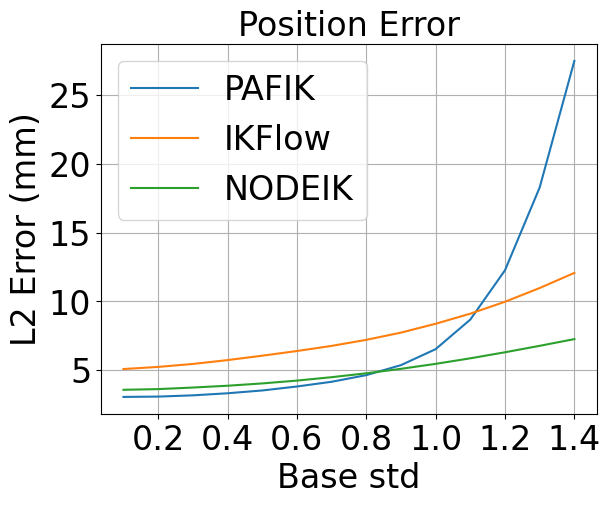

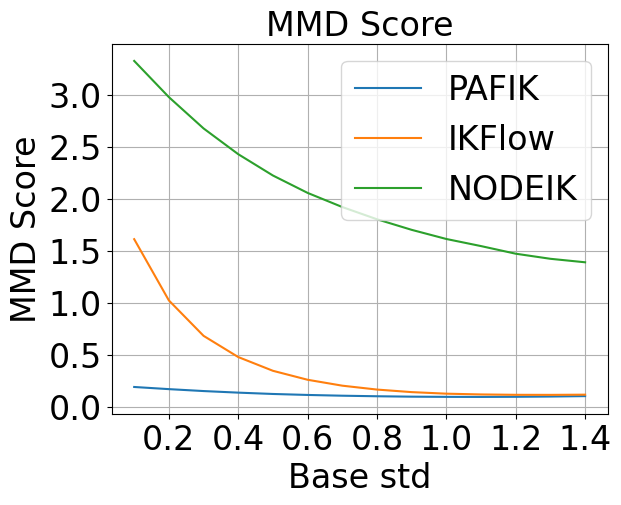

In [22]:
df = pd.DataFrame({
    "l2_paik": df_paik.l2.values * 1000,
    "ang_paik": df_paik.ang.values,
    "mmd_paik": df_paik.mmd.values,
    
    "l2_ikflow": df_ikflow.l2.values * 1000,
    "ang_ikflow": df_ikflow.ang.values,
    "mmd_ikflow": df_ikflow.mmd.values,
    
    "l2_nodeik": df_nodeik.l2.values * 1000,
    "ang_nodeik": df_nodeik.ang.values,
    "mmd_nodeik": df_nodeik.mmd.values,
    
    "base_std": df_paik.base_std.values,
})

df.to_pickle(f"{record_dir}/three_methods_posture_mmd_std.pkl")

df_l2 = pd.DataFrame({
    "paik": df_paik.l2.values * 1000,
    "IKFlow": df_ikflow.l2.values * 1000,
    "NODEIK": df_nodeik.l2.values * 1000,
    "base std": df_paik.base_std.values,
})

df_mmd = pd.DataFrame({
    "paik": df_paik.mmd.values,
    "IKFlow": df_ikflow.mmd.values,
    "NODEIK": df_nodeik.mmd.values,
    "base std": df_paik.base_std.values,
})

fontsize = 24
ax1 = df_l2.plot(x="base std", grid=True, fontsize=fontsize)
ax1.set_ylabel("L2 Error (mm)", fontsize=fontsize)
ax1.set_xlabel("Base std", fontsize=fontsize)
ax1.set_title("Position Error", fontsize=fontsize)
ax1.legend(fontsize=fontsize)

ax1 = df_mmd.plot(x="base std", grid=True, fontsize=fontsize)
ax1.set_ylabel("MMD Score", fontsize=fontsize)
ax1.set_xlabel("Base std", fontsize=fontsize)
ax1.set_title("MMD Score", fontsize=fontsize)
ax1.legend(fontsize=fontsize)

# Load J_hat's, J, and P for further mmd research

Apply inverse multi-quadric kernel as rbf kernel

In [5]:
import numpy as np

J_hat_paik = np.load(f"{record_dir}/J_hat_paik.npy")
J_hat_ikflow = np.load(f"{record_dir}/J_hat_ikflow.npy")
J_hat_nodeik = np.load(f"{record_dir}/J_hat_nodeik.npy")
J_ground_truth = np.load(f"{record_dir}/numerical_ik_sols.npy")

J_hat_paik.shape, J_hat_ikflow.shape, J_hat_nodeik.shape, J_ground_truth.shape

((14, 1000, 2000, 7),
 (14, 1000, 2000, 7),
 (14, 1000, 2000, 7),
 (1000, 2000, 7))

100%|██████████| 14/14 [06:19<00:00, 27.13s/it, mmd_pafik=0.156, mmd_ikflow=0.157, mmd_nodeik=0.779]


<AxesSubplot: title={'center': 'mmd vs. Base Std'}, xlabel='base_std'>

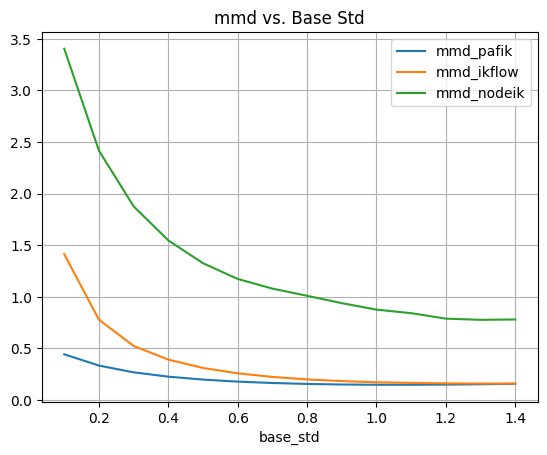

In [6]:
from tqdm import trange
from mmd_helper import mmd_evaluate_multiple_poses

num_base_stds, num_poses, num_sols, num_dofs = J_hat_paik.shape
mmd_paik, mmd_ikflow, mmd_nodeik = np.empty((num_base_stds)), np.empty((num_base_stds)), np.empty((num_base_stds))
use_inverse_multi_quadric = True


for i in (pbar := trange(num_base_stds)):
    mmd_paik[i] = mmd_evaluate_multiple_poses(
        J_hat_paik[i], J_ground_truth, num_poses=num_poses, use_inverse_multi_quadric=use_inverse_multi_quadric
    )
    mmd_ikflow[i] = mmd_evaluate_multiple_poses(
        J_hat_ikflow[i], J_ground_truth, num_poses=num_poses, use_inverse_multi_quadric=use_inverse_multi_quadric
    )
    mmd_nodeik[i] = mmd_evaluate_multiple_poses(
        J_hat_nodeik[i], J_ground_truth, num_poses=num_poses, use_inverse_multi_quadric=use_inverse_multi_quadric
    )
    pbar.set_postfix({
        "mmd_paik": mmd_paik[i],
        "mmd_ikflow": mmd_ikflow[i],
        "mmd_nodeik": mmd_nodeik[i],
    })

df_mmd = pd.DataFrame({
    "mmd_paik": mmd_paik,
    "mmd_ikflow": mmd_ikflow,
    "mmd_nodeik": mmd_nodeik,
    "base_std": df.base_std.values,
})
df_mmd.plot(x="base_std", y=["mmd_paik", "mmd_ikflow", "mmd_nodeik"], title="mmd vs. Base Std", grid=True)

In [6]:
df_mmd.describe()

,mmd_pafik,mmd_ikflow,mmd_nodeik,base_std
count,14.000000,14.000000,14.000000,14.00000
mean,0.203382,0.362664,1.343957,0.75000
std,0.087779,0.350233,0.760431,0.41833
min,0.145724,0.157391,0.775421,0.10000
25%,0.149039,0.165639,0.848593,0.42500
50%,0.159278,0.209904,1.043319,0.75000
75%,0.217467,0.369477,1.490142,1.07500
max,0.441158,1.412001,3.403252,1.40000


In [ ]:
import torch

In [ ]:
num_X, num_Y = 100, 101
num_features = 7
num_samples = num_X + num_Y

X, Y = torch.randn(num_X, num_features)*3, torch.randn(num_Y, num_features)*(-10)

In [ ]:
XY = torch.vstack([X, Y])
XY.shape

In [ ]:
total = torch.cat([X, Y], dim=0)
total0 = total.unsqueeze(0).expand(
    int(total.size(0)), int(total.size(0)), int(total.size(1))
)
total1 = total.unsqueeze(1).expand(
    int(total.size(0)), int(total.size(0)), int(total.size(1))
)
L2_distance_total = ((total0 - total1) ** 2).sum(2)

In [ ]:
L2_distance = torch.cdist(XY, XY) ** 2

In [ ]:
L2_distance_total.shape, L2_distance.shape

In [ ]:
# compute the difference between the L2_distance and L2_distance_total
(L2_distance_total - L2_distance).abs().median()

In [ ]:
xx, yy, xy = torch.mm(X, X.t()), torch.mm(Y, Y.t()), torch.mm(X, Y.t())

rx = xx.diag().unsqueeze(0).expand_as(xx)
ry = yy.diag().unsqueeze(0).expand_as(yy)

dist_xx = torch.clamp(rx.t() + rx - 2.0 * xx, 0, torch.inf)
# dist_yy = torch.clamp(ry.t() + ry - 2.0 * yy, 0, torch.inf)
# dist_xy = torch.clamp(rx.t() + ry - 2.0 * xy, 0, torch.inf)

In [ ]:
dist_xx

In [ ]:
XX = torch.cdist(X, X) ** 2
XX

In [ ]:
import torch

X = torch.randn(2, 3)
X.mean()